### This notebook is for exploration and development (prototyping) purposes.

In [1]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import scipy.stats as stats
from statsmodels.stats import multitest
import copy

import sys
sys.path.insert(1, "../code/utils")
sys.path.insert(1, "../code/data_modification")
from celldata import *
from effects import *

In [2]:
def get_significant_feature_inds(rejections, n, k):
    # rejections is a boolean array of length n*k (from BH)
    # n is the number of features
    # k is the number of pairwise comparisons
    inds = np.zeros((n,k), dtype=bool)
    for i in range(6):
        inds[:,i] = rejections[i*n:(i+1)*n]
    return inds.any(axis=1)



def remove_effectsV1(x, rejections, factor=lambda: 1.0):
    # rejections is a boolean array of length n*k (from BH)
    # factor is the factor to multiply each groups mean by
    # and might be better to be slightly less than 1
    # to leave some effect -- this is to leave more variability
    # in the data
    n = x.shape[0]
    k = len(rejections) // n
    assert n*k == len(rejections)
    inds = get_significant_feature_inds(rejections, n, k)
    data = copy.deepcopy(x)
    # remove the effect of significant features by first saving the mean of group UT
    UT_mean = np.mean(data[:,30:40], axis=1)
    # Then center all groups in significant features to zero
    data[inds,:10] -= factor()*np.mean(data[inds,:10], axis=1)[:,np.newaxis]
    data[inds,10:20] -= factor()*np.mean(data[inds,10:20], axis=1)[:,np.newaxis]
    data[inds,20:30] -= factor()*np.mean(data[inds,20:30], axis=1)[:,np.newaxis]
    data[inds,30:40] -= factor()*np.mean(data[inds,30:40], axis=1)[:,np.newaxis]
    
    data[inds,:] += UT_mean[inds][:,np.newaxis]
    return data

def remove_effectsV2(x1, x2, rejections, factor=lambda : 1.0):
    # rejections is a boolean array of length n*k (from BH)
    # factor is the factor to multiply each groups mean by
    # and might be better to be slightly less than 1
    # to leave some effect -- this is to leave more variability
    # in the data. X has the pairwise comparisons in the last dimension
    n = x1.shape[0]
    x1 = copy.deepcopy(x1)
    x2 = copy.deepcopy(x2)
    means1 = np.mean(x1, axis=1)
    means2 = np.mean(x2, axis=1)
    
    for i in range(n):
        if rejections[i]:
            # set rejections[j]=0 at j= i, i*2, i*3, i*4, i*5, i*6
            for j in range(6):
                rejections[i+j*n] = False
            # check which group is the highest and remove the effect
            # by setting the group mean to zero
            if means1[i] > means2[i]:
                x1[i,:10] -= factor()*(np.mean(x1[i,:10]) - means2[i])
            else:
                x2[i,:10] -= factor()*(np.mean(x2[i,:10]) - means1[i])
                
    return x1, x2

    

def generate_single_shifts(x, m1, shift=1.0):
    # m1 is the number of groups to shift (or fraction of groups to shift)
    # shift is the amount to shift by
    if m1 < 1:
        m1 = int(m1*x.shape[0])
    group_inds = np.array([np.arange(10), np.arange(10,20), np.arange(20,30), np.arange(30,40)])
    data = copy.deepcopy(x)
    row_inds = np.random.choice(data.shape[0], m1, replace=False)
    col_inds = np.array([np.random.choice(np.arange(4), 1)[0] for _ in range(m1)])
    mask = np.zeros((data.shape[0], 4), dtype=bool)
    mask[row_inds, col_inds] = True
    
    for i in range(m1):
        data[row_inds[i], group_inds[col_inds[i]]] += shift
    print("Shifted %d cells" % m1)
    print("Now %d significant features" % (m1*3))
    return data, mask

def generate_double_shifts(x, m1, shift=1.0):
    # like generate_single_shifts but now we shift two groups at a time
    # (results in 4 effects per feature)
    if m1 < 1:
        m1 = int(m1*x.shape[0])
    group_inds = np.array([np.arange(10), np.arange(10,20), np.arange(20,30), np.arange(30,40)])
    data = copy.deepcopy(x)
    row_inds = np.random.choice(data.shape[0], m1, replace=False)
    col_inds = np.array([np.random.choice(np.arange(4), 2, replace=False) for _ in range(m1)])
    mask = np.zeros((data.shape[0], 4), dtype=bool)
    mask[row_inds, col_inds[:,0]] = True
    mask[row_inds, col_inds[:,1]] = True
    
    for i in range(m1):
        data[row_inds[i], group_inds[col_inds[i]]] += shift
    print("Shifted %d cells" % m1)
    print("Now %d significant features" % (m1*4))
    return data, mask

def generate_random_single_shifts(x, m1, position=1.0, scale=1.0):
    # like generate_single_shifts but shifts are random
    # by setting scale to 0, the shifts are deterministic
    # and position is the amount to shift by
    if m1 < 1:
        m1 = int(m1*x.shape[0])
    group_inds = np.array([np.arange(10), np.arange(10,20), np.arange(20,30), np.arange(30,40)])
    data = copy.deepcopy(x)
    row_inds = np.random.choice(data.shape[0], m1, replace=False)
    col_inds = np.array([np.random.choice(np.arange(4), 1)[0] for _ in range(m1)])
    mask = np.zeros((data.shape[0], 4), dtype=bool)
    mask[row_inds, col_inds] = True
    
    for i in range(m1):
        data[row_inds[i], group_inds[col_inds[i]]] += position + scale*np.random.normal(0, 1)
    print("Shifted %d cells" % m1)
    print("Now %d significant features" % (m1*3))
    
    return data, mask

def generate_random_double_shifts(x, m1, position=1.0, scale=1.0):
    # like generate_random_single_shifts but shifts are random
    # and now we shift two groups at a time (results in 4 effects per feature)
    if m1 < 1:
        m1 = int(m1*x.shape[0])
    group_inds = np.array([np.arange(10), np.arange(10,20), np.arange(20,30), np.arange(30,40)])
    data = copy.deepcopy(x)
    row_inds = np.random.choice(data.shape[0], m1, replace=False)
    col_inds = np.array([np.random.choice(np.arange(4), 2, replace=False) for _ in range(m1)])
    mask = np.zeros((data.shape[0], 4), dtype=bool)
    mask[row_inds, col_inds[:,0]] = True
    mask[row_inds, col_inds[:,1]] = True
    
    for i in range(m1):
        data[row_inds[i], group_inds[col_inds[i]]] += position + scale*np.random.normal(0, 1)
    print("Shifted %d cells" % m1)
    print("Now %d significant features" % (m1*4))
    
    return data, mask

def generate_random_effect_maskV1(n, m1):
    # generate a random mask for effects. m1 is the number of effects
    # to generate, n_groups_max is the maximum number of groups to
    # generate effects for. Mask is x.shape[0] x 4 boolean array
    # where True means that the effect is present. The position of the
    # effect is random and in total m1 positions are True.
    if m1 < 1:
        m1 = int(m1*n)
    mask = np.zeros((n, 4), dtype=bool)
    mask_flat = mask.flatten()
    mask_flat[np.random.choice(len(mask_flat), m1, replace=False)] = True
    mask = mask_flat.reshape(mask.shape)
    return mask

def generate_random_effect_maskV2(n, m1, n_groups_max=[1]):
    # like the above function but now we can generate effects 
    # one feature at a time and shift up to n_groups_max groups
    # for each feature
    if m1 < 1:
        m1 = int(m1*n)
    mask = np.zeros((n, 4), dtype=bool)
    count=0
    for i in range(n):
        n_effects = np.random.choice(n_groups_max, 1)
        count += n_effects
        # if count >m1, subtract the excess from the last feature
        if count > m1:
            n_effects -= count - m1
        mask[i, np.random.choice(np.arange(4), n_effects, replace=False)] = True
        if count >= m1:
            break
    
    return mask

def generate_random_model_shifts(x, effects, model):
    # like the above functions but now we insert pre-generated effects
    # into the data.
    # x is n x d ndarray -- n features, d samples (cells) in 4 groups (celldata)
    # effects is a n x 4 float ndarray mask.
    # model is the model to use to generate the data -- it sho9uld take no arguments
    # and always return a single float -- e.g., np.random.normal(0, 1), or lambda: constant
    group_inds = np.array([np.arange(10), np.arange(10,20), np.arange(20,30), np.arange(30,40)])
    data = copy.deepcopy(x)
    
    for i in range(data.shape[0]):
        for j in range(4):
            if effects[i,j]:
                data[i, group_inds[j]] += model()
    return data, effects
    
    
    

In [3]:
pathIN = "../data/unmodified_data/"
filenames = [line.split('\n')[0] for line in open(pathIN + "filenames.txt")][:6]
for i in  range(len(filenames)):print(filenames[i])
pathOUT = "../data/modified_data/"

cellshilicnegGFstatus.csv
cellshilicposGFstatus.csv
cellslipidnegGFstatus.csv
cellslipidposGFstatus.csv
cellsRPnegGFstatus.csv
cellsRPposGFstatus.csv


In [31]:
np.random.seed(0)
fnum=1
fname = filenames[fnum]
data = compile_ttest_features(pathIN, fname)
area = data['AREA']
gaps = data['GAPS']
groups = data['GROUPS']

fnameOUT = "RESIDUALS_" + fname
print("Saving data to %s" % pathOUT + fnameOUT)

Reading data from: ../data/unmodified_data/cellshilicposGFstatus.csv
Saving data to ../data/modified_data/RESIDUALS_cellshilicposGFstatus.csv


In [25]:
'''
# get RESIDUALS and save them
area[:,0:10] -= area[:,0:10].mean(axis=1)[:,np.newaxis]
area[:,10:20] -= area[:,10:20].mean(axis=1)[:,np.newaxis]
area[:,20:30] -= area[:,20:30].mean(axis=1)[:,np.newaxis]
area[:,30:40] -= area[:,30:40].mean(axis=1)[:,np.newaxis]

# append i=1,2,...,40 to group names
group_names = np.array([g + str(i+1) for i,g in enumerate(groups)])
group_gaps = np.array(["gap_" + g + str(i+1) for i,g in enumerate(groups)])
# make a dataframe from the data. The columns are the group names for area and gaps
df = pd.DataFrame(data=area, columns=group_names)
df_gaps = pd.DataFrame(data=gaps, columns=group_gaps)
# combine the two dataframes
df = pd.concat([df, df_gaps], axis=1)
df.head()

# save the data
df.to_csv(pathOUT + fnameOUT, index=False, header=True, sep=';')
'''

In [32]:
aSYN = area[:,0:10]
comb = area[:,10:20]
IFNg = area[:,20:30]
UT = area[:,30:40]

dataX = np.vstack((aSYN, comb, IFNg, aSYN, comb, aSYN))
dataY = np.vstack((UT,   UT,   UT,   IFNg, IFNg, comb))        

testXY = np.hstack((dataX, dataY))

result = stats.ttest_ind(dataX, dataY, axis=1, equal_var=False, nan_policy='raise')

# NOTE BH is the default method for removing group means
multitest_method = 'fdr_bh'
rejected, p_corrected, alphacSidak, alphacBonf = multitest.multipletests(result.pvalue, alpha=0.05, method=multitest_method)
print("Number of significant tests: ", np.sum(rejected))

Number of significant tests:  463


In [33]:
area_cor_vector = np.corrcoef(area)
# keep only the upper triangle and no diagonal
area_cor_vector = area_cor_vector[np.triu_indices(area_cor_vector.shape[0], k = 1)]

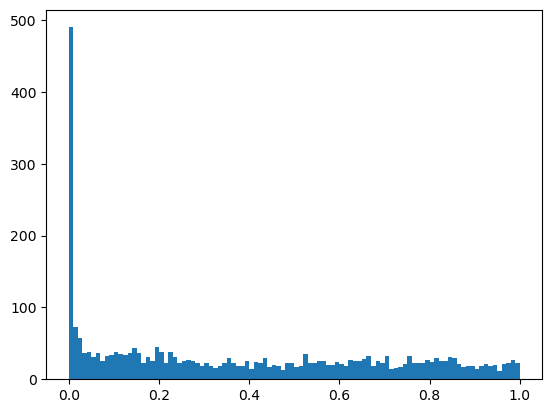

In [34]:
plt.hist(result.pvalue, bins=100)
plt.show()

In [35]:
np.all(gaps.shape == area.shape)

True

In [36]:
fac = lambda: 0.9 + 0.01*np.random.uniform(0, 1)
area = remove_effectsV1(area, rejected, factor=fac)

In [37]:
aSYN = area[:,0:10]
comb = area[:,10:20]
IFNg = area[:,20:30]
UT = area[:,30:40]

dataX = np.vstack((aSYN, comb, IFNg, aSYN, comb, aSYN))
dataY = np.vstack((UT,   UT,   UT,   IFNg, IFNg, comb))        

testXY = np.hstack((dataX, dataY))

result = stats.ttest_ind(dataX, dataY, axis=1, equal_var=False, nan_policy='raise')

# NOTE BH is the default method for removing group means
multitest_method = 'fdr_bh'
rejected, p_corrected, alphacSidak, alphacBonf = multitest.multipletests(result.pvalue, alpha=0.05, method=multitest_method)
print("Number of significant tests: ", np.sum(rejected))

Number of significant tests:  0


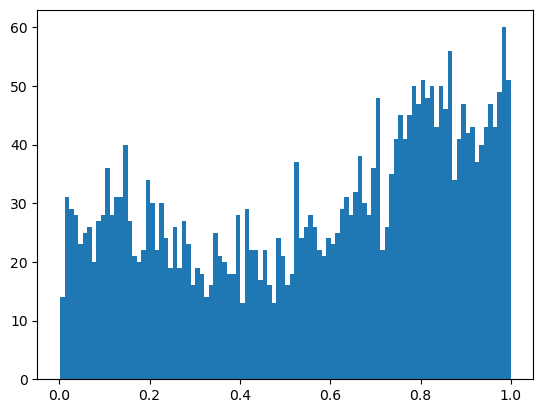

In [38]:
plt.hist(result.pvalue, bins=100)
plt.show()

In [39]:
np.all(gaps.shape == area.shape)

True

In [40]:
# append i=1,2,...,40 to group names
group_names = np.array([g + str(i+1) for i,g in enumerate(groups)])
group_gaps = np.array(["gap_" + g + str(i+1) for i,g in enumerate(groups)])
# make a dataframe from the data. The columns are the group names for area and gaps
df = pd.DataFrame(data=area, columns=group_names)
df_gaps = pd.DataFrame(data=gaps, columns=group_gaps)
# combine the two dataframes
df = pd.concat([df, df_gaps], axis=1)
df.head()

,aSYN1,aSYN2,aSYN3,aSYN4,aSYN5,aSYN6,aSYN7,aSYN8,aSYN9,aSYN10,...,gap_UT31,gap_UT32,gap_UT33,gap_UT34,gap_UT35,gap_UT36,gap_UT37,gap_UT38,gap_UT39,gap_UT40
0,30.056512,30.139410,29.617636,30.028271,29.549291,29.641627,29.864923,29.143709,29.750520,29.930421,...,0,0,0,0,0,0,0,0,0,0
1,29.099967,29.242599,28.801000,29.750701,28.469814,28.770308,29.140311,29.030912,28.296378,30.098802,...,0,0,0,0,0,0,0,0,0,0
2,30.693177,30.933889,30.115356,30.533252,29.767990,29.904533,30.376764,29.919548,30.029115,30.825886,...,0,0,0,0,0,0,0,0,0,0
3,28.393098,28.576054,26.791889,26.822442,27.370288,27.291797,27.078640,27.704457,26.726185,26.814325,...,0,0,0,0,0,0,0,0,0,0
4,28.061932,28.212662,26.747026,26.784336,27.247022,27.161893,26.969085,27.501903,26.685132,26.747085,...,0,0,0,0,0,0,0,0,0,0


In [41]:
centered_area = df.iloc[:,:40].to_numpy()
centered_area_cor_vector = np.corrcoef(centered_area)
# keep only the upper triangle and no diagonal
centered_area_cor_vector = centered_area_cor_vector[np.triu_indices(centered_area_cor_vector.shape[0], k = 1)]

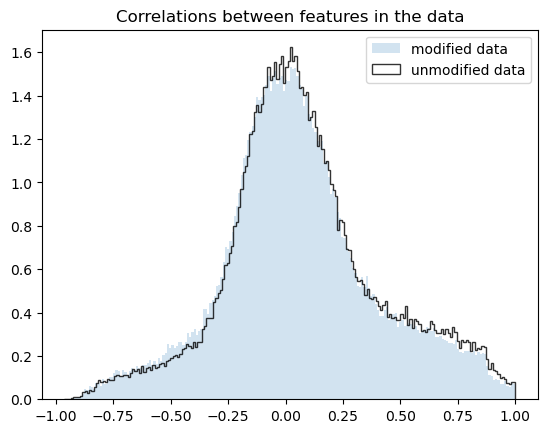

In [42]:
plt.hist(centered_area_cor_vector, bins = 200, alpha = 0.2, label = 'modified data', density=True)
plt.hist(area_cor_vector, bins = 200, alpha = 0.8, label = 'unmodified data', histtype=u'step', color='k', density=True)
plt.title('Correlations between features in the data')
plt.legend()
plt.show()

In [76]:
# save the data
#df.to_csv(pathOUT + fnameOUT, index=False, header=True, sep=';')

In [11]:
rejected, p_corrected, alphacSidak, alphacBonf = multitest.multipletests(p_uncorrected, alpha=0.05, method=multitest_method)
print("Number of significant tests: ", np.sum(rejected))
dataX_removed, dataY_removed = remove_effectsV2(dataX, dataY, rejected)
result = stats.ttest_ind(dataX_removed, dataY_removed, axis=1, equal_var=False, nan_policy='raise')
multitest_method = 'fdr_bh'
rejected, p_corrected, alphacSidak, alphacBonf = multitest.multipletests(result.pvalue, alpha=0.05, method=multitest_method)
print("Number of significant tests: ", np.sum(rejected))

Number of significant tests:  70


IndexError: index 892 is out of bounds for axis 0 with size 786

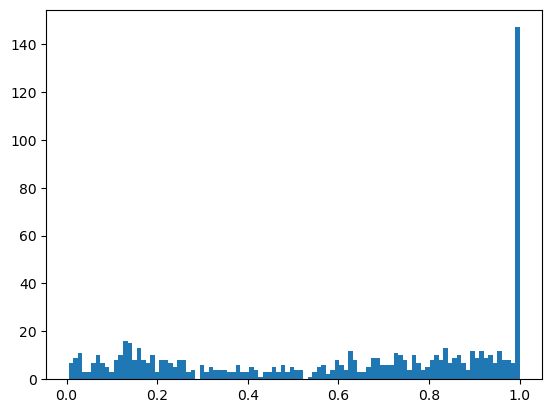

In [395]:
plt.hist(result.pvalue, bins=100)
plt.show()

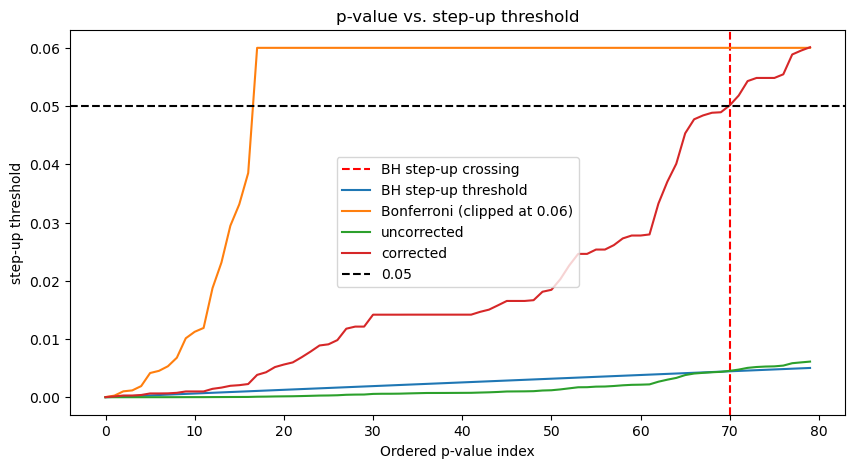

In [188]:
# plot the uncorrected p-values against the benjamini-hochberg step-up adjusted threshold
inds = np.argsort(p_uncorrected)[:80]
plt.figure(figsize=(10,5))
i = np.arange(len(p_uncorrected))[:80]
steps = 0.05*i/len(p_uncorrected)
# draw vertical lines at the step-up threshold
v_ind = np.where(p_uncorrected[inds]>steps)[0][1]
plt.axvline(v_ind, color='r', linestyle='--', label='BH step-up crossing')
plt.plot(i, steps, label='BH step-up threshold')
plt.plot(i, np.minimum(p_uncorrected[inds]*len(p_uncorrected), .06), label='Bonferroni (clipped at 0.06)')
plt.plot(i, p_uncorrected[inds], label='uncorrected')
plt.plot(i, p_corrected[inds], label='corrected')
plt.axhline(0.05, color='k', linestyle='--', label='0.05')
plt.legend()
plt.xlabel('Ordered p-value index')
plt.ylabel('step-up threshold')
plt.title('p-value vs. step-up threshold')
plt.show()

In [12]:
area_cor_vector = np.corrcoef(area)
# keep only the upper triangle and no diagonal
area_cor_vector = area_cor_vector[np.triu_indices(area_cor_vector.shape[0], k = 1)]

In [13]:
testXY_cor_vector = np.corrcoef(testXY)
# keep only the upper triangle and no diagonal
testXY_cor_vector = testXY_cor_vector[np.triu_indices(testXY_cor_vector.shape[0], k = 1)]

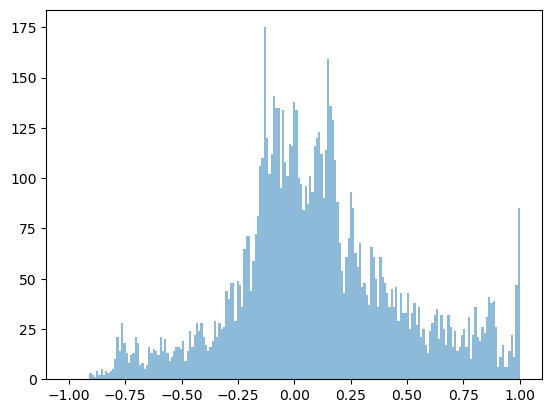

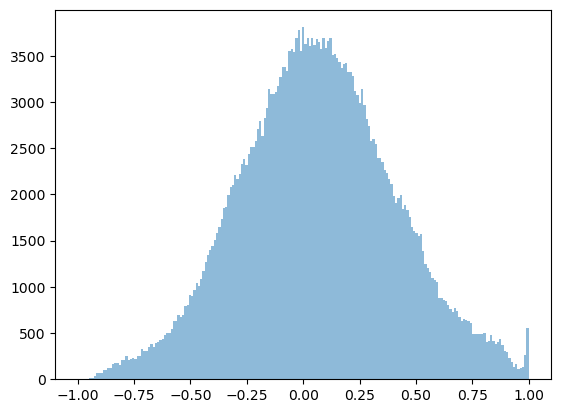

In [14]:
bins=np.linspace(-1,1,200)
plt.hist(area_cor_vector, bins = bins, alpha = 0.5, label = 'area')
plt.show()
plt.hist(testXY_cor_vector, bins = bins, alpha = 0.5, label = 'testXY')
plt.show()

In [115]:
D=compile_ttest_features(pathIN, filenames[2])
D=filter_features(D, lambda x: (np.var(x, 1, ddof=1)>=0, np.var(x, 1, ddof=1)), verbose=True, method='no filter')
D=compile_ttest_groups(D, verbose=True)

Reading data from: ../data/unmodified_data/cellslipidnegGFstatus.csv
Filtering features
Features before: 1135
Features removed: 0
Features after: 1135
Filtering method: no filter
Number of tests: 6810


In [116]:
result = stats.ttest_ind(D['dataX'], D['dataY'], axis=1, equal_var=False, nan_policy='raise')
p_uncorrected = result.pvalue

multitest_method = 'fdr_by'
rejected, p_corrected, alphacSidak, alphacBonf = multitest.multipletests(p_uncorrected, alpha=0.05, method=multitest_method)

In [117]:
testXY = np.hstack((D['dataX'], D['dataY']))
testXY_not_rejected = testXY[~rejected]
testXY_rejected = testXY[rejected]

In [118]:
area_cor_vector = np.corrcoef(D['AREA'])
# keep only the upper triangle and no diagonal
area_cor_vector = area_cor_vector[np.triu_indices(area_cor_vector.shape[0], k = 1)]

In [119]:
testXY_cor_vector = np.corrcoef(testXY)
# keep only the upper triangle and no diagonal
testXY_cor_vector = testXY_cor_vector[np.triu_indices(testXY_cor_vector.shape[0], k = 1)]

In [120]:
testXY_rejected_cor_vector = np.corrcoef(testXY_rejected)
testXY_rejected_cor_vector = testXY_rejected_cor_vector[np.triu_indices(testXY_rejected_cor_vector.shape[0], k = 1)]
testXY_not_rejected_cor_vector = np.corrcoef(testXY_not_rejected)
testXY_not_rejected_cor_vector = testXY_not_rejected_cor_vector[np.triu_indices(testXY_not_rejected_cor_vector.shape[0], k = 1)]

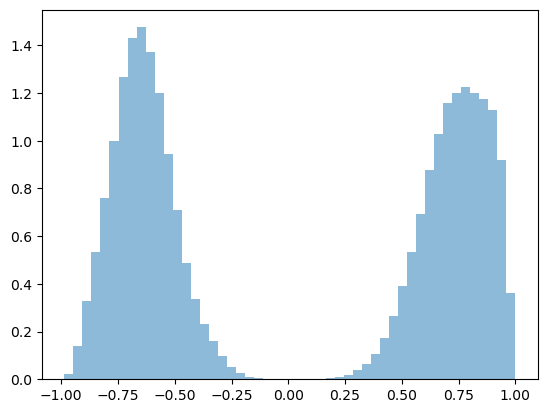

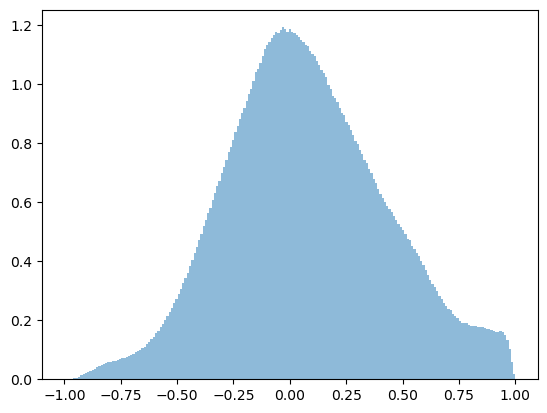

In [121]:
# plot the correlation of the rejected and not rejected features in different plots
bins=np.linspace(-1,1,200)
plt.hist(testXY_rejected_cor_vector, bins = 50, density=True, alpha = 0.5, label = 'testXY rejected')
plt.show()
plt.hist(testXY_not_rejected_cor_vector, bins = bins, density=True, alpha = 0.5, label = 'testXY not rejected')
plt.show()

In [122]:
# center each group in area
asyn_means = D['AREA'][:,0:10].mean(axis=1)
comb_means = D['AREA'][:,10:20].mean(axis=1)
IFNg_means = D['AREA'][:,20:30].mean(axis=1)
UT_means = D['AREA'][:,30:40].mean(axis=1)

centered_asyn = D['AREA'][:,0:10] - asyn_means[:,np.newaxis]
centered_comb = D['AREA'][:,10:20] - comb_means[:,np.newaxis]
centered_IFNg = D['AREA'][:,20:30] - IFNg_means[:,np.newaxis]
centered_UT = D['AREA'][:,30:40] - UT_means[:,np.newaxis]

centered_area = np.hstack((centered_asyn, centered_comb, centered_IFNg, centered_UT))

In [123]:
centered_area_cor_vector = np.corrcoef(centered_area)
# keep only the upper triangle and no diagonal
centered_area_cor_vector = centered_area_cor_vector[np.triu_indices(centered_area_cor_vector.shape[0], k = 1)]

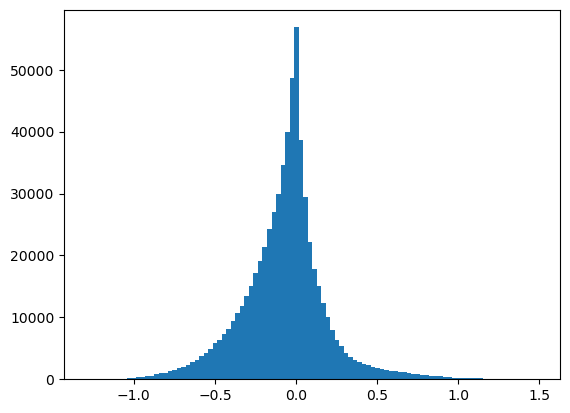

In [124]:
plt.hist((centered_area_cor_vector-area_cor_vector), bins=100)
plt.show()

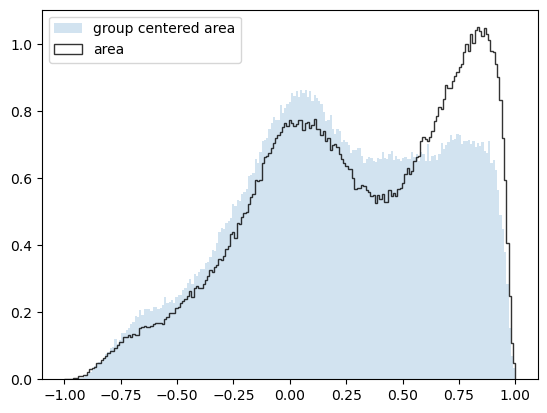

In [125]:
plt.hist(centered_area_cor_vector, bins = bins, alpha = 0.2, label = 'group centered area', density=True)
plt.hist(area_cor_vector, bins = bins, alpha = 0.8, label = 'area', histtype=u'step', color='k', density=True)
plt.legend()
plt.show()